# Analiza zbioru danych<br>
https://www.kaggle.com/impapan/student-performance-data-set

## Import pakietów

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import os, os.path as op

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def plot_estimates(estimates=None, model=None, figsize=(12,8), boundaries=None, vline=True):

    def get_estimates(model, long=True):
        est = model.conf_int().rename(columns={0:"LL",1:"UL"})
        est.insert(0,"coef", model.params)
        est = est.reset_index().rename(columns={"index":"variable"})

        return est
    
    
    if estimates is None:
        estimates = get_estimates(model)
    
    fig, ax = plt.subplots(figsize=figsize)

    plt.errorbar(estimates['coef'], estimates.index, xerr=(estimates.UL - estimates.LL)/2, fmt='o', color='black',
                 ecolor=estimates.coef.apply(lambda c: '#E41A1C' if c < 0 else '#029E73'), elinewidth=3, capsize=0)

    plt.yticks(ticks=estimates.index,labels=estimates['variable'])

    if boundaries is not None:
        plt.xlim(boundaries[0],boundaries[1])
        
    if vline == True:
        plt.axvline(0,color='black',linewidth=2,alpha=.8,linestyle="--")
    

    plt.xlabel("Estimate")
    plt.ylabel("")
    plt.show()

## Załadowanie danych

In [3]:
data = pd.read_csv(op.join('data', 'student', 'student-mat.csv'), sep =';')

In [4]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


#### Opis danych sporządzony przez twórcce bazy danych:
1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)<br>
2 sex - student's sex (binary: "F" - female or "M" - male)<br>
3 age - student's age (numeric: from 15 to 22)<br>
4 address - student's home address type (binary: "U" - urban or "R" - rural)<br>
5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)<br>
6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)<br>
7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)<br>
8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)<br>
9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")<br>
10 Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")<br>
11 reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")<br>
12 guardian - student's guardian (nominal: "mother", "father" or "other")<br>
13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)<br>
14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)<br>
15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)<br>
16 schoolsup - extra educational support (binary: yes or no)<br>
17 famsup - family educational support (binary: yes or no)<br>
18 paid - extra paid classes within the course subject -Math (binary: yes or no)<br>
19 activities - extra-curricular activities (binary: yes or no)<br>
20 nursery - attended nursery school (binary: yes or no)<br>
21 higher - wants to take higher education (binary: yes or no)<br>
22 internet - Internet access at home (binary: yes or no)<br>
23 romantic - with a romantic relationship (binary: yes or no)<br>
24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)<br>
25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)<br>
26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)<br>
27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)<br>
28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)<br>
29 health - current health status (numeric: from 1 - very bad to 5 - very good)<br>
30 absences - number of school absences (numeric: from 0 to 93)<br>
<br>
#### these grades are related with the course subject- Math:<br>
31 G1 - first period grade (numeric: from 0 to 20)<br>
31 G2 - second period grade (numeric: from 0 to 20)<br>
32 G3 - final grade (numeric: from 0 to 20, output target)<br>

## Test t-studenta dla prób niezależnych

Czy wielkość rodziny ucznia wpływa na jego oceną końcową?

H0:Wielkość rodziny nie wpływa na ocene końcową ucznia<br>
H1:Wielkość rodziny wpływa na ocene końcową ucznia

In [5]:
data['famsize'].unique()

array(['GT3', 'LE3'], dtype=object)

'GT3' - duża rodzina <br>
'LE3' - mała rodzina <br>
'G3' - ocena końcowa

In [6]:
mała_rodzina = data[data['famsize'] =='LE3']['G3']

duża_rodzina = data[data['famsize'] =='GT3']['G3']

In [7]:
mała_rodzina.agg([min,max, np.mean,np.median,np.std,len ]).round(3)


min         0.000
max        19.000
mean       11.000
median     11.000
std         4.226
len       114.000
Name: G3, dtype: float64

In [8]:
z_mała = (mała_rodzina - mała_rodzina.mean()) / mała_rodzina.std()
print(z_mała[z_mała> 3])
print(z_mała[z_mała< -3])

Series([], Name: G3, dtype: float64)
Series([], Name: G3, dtype: float64)


Brak dewiantów dla małej rodziny

In [9]:
duża_rodzina.agg([min,max, np.mean,np.median,np.std,len ]).round(3)

min         0.000
max        20.000
mean       10.178
median     11.000
std         4.705
len       281.000
Name: G3, dtype: float64

In [10]:
z_duża = (duża_rodzina - duża_rodzina.mean()) / duża_rodzina.std()
print(z_duża[z_duża> 3])
print(z_duża[z_duża< -3])

Series([], Name: G3, dtype: float64)
Series([], Name: G3, dtype: float64)


Brak dewiantów dla dużej rodziny

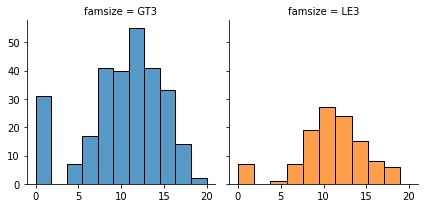

In [11]:
g =sns.FacetGrid(data, col ='famsize', hue ='famsize')
g.map_dataframe(sns.histplot, x ='G3');

In [12]:
pg.ttest(mała_rodzina, duża_rodzina, correction ='auto').round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.694,231.571,two-sided,0.092,"[-0.13, 1.78]",0.18,0.483,0.365



W celu sprawdzenia czy wielkość rodziny wpływa na ocenę końcową ucznia przeprowadzono test t-studenta dla prób niezależnych. Wynik analizy okazał się nieistotny statystycznie t(231.571) = 1.694 ; p = 0.092 ; d = 0.18. Między uczniami z mniejszych rodzin (mean = 11.0 ; std = 4.226) i uczniami z większych rodzin (mean = 10.178; std = 4.7045) nie zauważono istotnych statystycznie różnic w ocenach. Hipoteza zerowa okazała się prawdziwa.


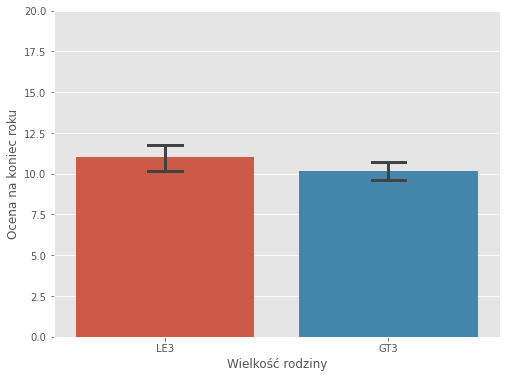

In [13]:
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x='famsize',y='G3',data=data,
            order=["LE3","GT3"],capsize=.15,errwidth=3)

ax.set_xlabel("Wielkość rodziny")
ax.set_ylabel("Ocena na koniec roku")

ax.set_ylim(0,20);


## Jednoczynnikowa analiza wariancji w schemacie międzygrupowym

Czy poziom wykształcenia matki ucznia wpływa na jego wyniki szkolne?

H0: Poziom wykształcenia matki ucznia nie wpływa na oceny ucznia w szkole. <br>
H1: Poziom wykształcenia matki ucznia wpływa na oceny ucznia w szkole.

Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education) <br>

Dane pochodzą z Portugalii w której system edukacji ma inny podział niż w Polsce. Dlatego pewnie dla twórcy tego zbioru danych wykształcenie podstawowe kończy się na 4 klasie. Postanowiłem trzymać się tej konwencji i 2 przedział edukacji od piątej do dziewiątej klasy postanowiłem nazwać wykształceniem podstawowym wyższym.

In [14]:
data['Medu'].unique()

array([4, 1, 3, 2, 0], dtype=int64)

In [15]:
data['Medu']= data['Medu'].map({0: 'brak', 1:'Podstawowe', 2:'Podstawowe wyższe', 3:'Średnie', 4: 'Wyższe'})

In [16]:
data.groupby('Medu')['G3'].agg([np.mean, np.median, np.std, np.min, np.max, len])

,mean,median,std,amin,amax,len
Medu,,,,,,
Podstawowe,8.677966,10,4.364594,0,16,59
Podstawowe wyższe,9.728155,11,4.636163,0,19,103
Wyższe,11.763359,12,4.267646,0,20,131
brak,13.000000,15,3.464102,9,15,3
Średnie,10.303030,10,4.623486,0,19,99


In [17]:
data['Medu'].unique()

array(['Wyższe', 'Podstawowe', 'Średnie', 'Podstawowe wyższe', 'brak'],
      dtype=object)

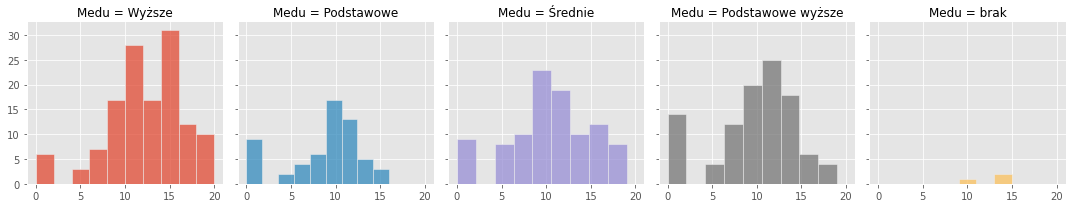

In [18]:
g = sns.FacetGrid(data, col ='Medu', hue ='Medu')
g.map_dataframe(sns.histplot, x ='G3');

Związku z tym że dane są nierównoliczne znowu postanowiłem zastosować dwa rozwiązania:
1. Nie używać czynnika brak wykształcenie bo zawiera on tylko 3 pomiary. Wylosować próbki zawierające po 50 pomiarów z pozostałych grup i na nich przeprowadzić analize ANOVA.
2. Biblioteka pingouin zawiera implematacje ANOVY Welcha, która jest odporna na nierównolicznośc grup.

### Próbkowanie danych i klasyczna ANOVA

In [19]:
import random 

wyzsze = data[data['Medu'] =='Wyższe']['G3']
wyzsze_probka = pd.DataFrame({'G3' : random.sample(list(wyzsze), k = 50), 'Wykształcenie' : 'Wyższe'})

srednie = data[data['Medu'] =='Średnie']['G3']
srednie_probka = pd.DataFrame({'G3' : random.sample(list(srednie), k = 50), 'Wykształcenie' : 'Średnie'})

podstawowe_wyzsze = data[data['Medu'] =='Podstawowe wyższe']['G3']
podstawowe_wyzsze_probka = pd.DataFrame({'G3' : random.sample(list(podstawowe_wyzsze), k = 50), 'Wykształcenie' : 'Podstawowe_wyższe'})

podstawowe = data[data['Medu'] =='Podstawowe']['G3']
podstawowe_probka = pd.DataFrame({'G3' : random.sample(list(podstawowe), k = 50), 'Wykształcenie' : 'Podstawowe'})

In [20]:
d = pd.concat([wyzsze_probka,srednie_probka,podstawowe_wyzsze_probka,podstawowe_probka])

In [21]:
d

,G3,Wykształcenie
0,10,Wyższe
1,0,Wyższe
2,11,Wyższe
3,12,Wyższe
4,13,Wyższe
...,...,...
45,13,Podstawowe
46,16,Podstawowe
47,8,Podstawowe
48,10,Podstawowe


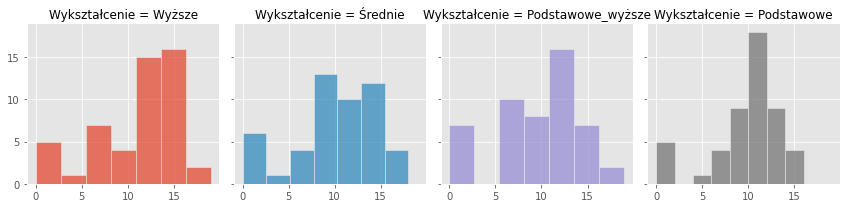

In [22]:
g = sns.FacetGrid(d, col ='Wykształcenie', hue ='Wykształcenie')
g.map_dataframe(sns.histplot, x ='G3');

In [23]:
d.groupby('Wykształcenie').agg([np.mean, np.std, np.min, np.max])

G3                    
                    mean       std amin amax
Wykształcenie                               
Podstawowe          9.32  3.925011    0   16
Podstawowe_wyższe   9.58  4.725485    0   19
Wyższe             10.82  4.783859    0   19
Średnie            10.04  4.789274    0   18

In [24]:
pg.anova(data = d, dv ='G3', between= 'Wykształcenie').round(4)

,Source,ddof1,ddof2,F,p-unc,np2
0,Wykształcenie,3,196,1.0359,0.3778,0.0156


In [25]:
pg.pairwise_ttests(data = d, dv = 'G3', between = 'Wykształcenie', effsize='cohen', padjust = 'sidak').round(4)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Wykształcenie,Podstawowe,Podstawowe_wyższe,False,True,-0.2993,98.0,two-sided,0.7654,0.9998,sidak,0.219,-0.0599
1,Wykształcenie,Podstawowe,Wyższe,False,True,-1.7141,98.0,two-sided,0.0897,0.4309,sidak,0.771,-0.3428
2,Wykształcenie,Podstawowe,Średnie,False,True,-0.8222,98.0,two-sided,0.4130,0.9591,sidak,0.285,-0.1644
3,Wykształcenie,Podstawowe_wyższe,Wyższe,False,True,-1.3040,98.0,two-sided,0.1953,0.7285,sidak,0.448,-0.2608
4,Wykształcenie,Podstawowe_wyższe,Średnie,False,True,-0.4834,98.0,two-sided,0.6299,0.9974,sidak,0.234,-0.0967
5,Wykształcenie,Wyższe,Średnie,False,True,0.8148,98.0,two-sided,0.4172,0.9608,sidak,0.283,0.1630


Przeprowadzono analizę jednoczynnikową ANOVA w schemacie międzygrupowym w celu sprawdzenia czy poziom wyszktałcenie matki wpływa na wyniki w nauce ucznia. Wynik analizy okazał się istotny statystycznie, F(3,196) = 4.1647; p = 0.0069 ; eta^2 = 0.0599. Wynik ety kwadrat wskazuje na występowanie silnego efektu poziomu wykształcenia matki ucznia. Porównania parami z korektą Sidaka wykazały istnienie istotnych statystycznie różnic między:
- Uczniami, których matka ma wykształcenie wyższe a tymi których matka ma wykształcenie podstawowe (p < 0.001)<br>

Nie wykazano różnic istotnych statystycznie dla reszty par.

Uczniowie, których matka posiada wykształcenie wyższe(mean = 11.72 ; std = 4.050901	) zdobywają lepsze oceny od uczniów, których matki posiadają wykształcenie podstawowe (mean = 8.68	 ; std = 4.419068)

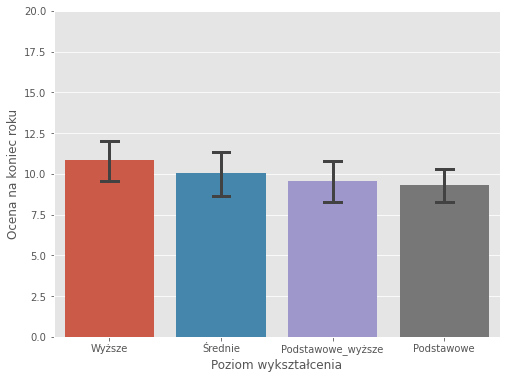

In [26]:
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x='Wykształcenie',y='G3',data=d,
            order=["Wyższe","Średnie","Podstawowe_wyższe", 'Podstawowe'],capsize=.15,errwidth=3)

ax.set_xlabel("Poziom wykształcenia")
ax.set_ylabel("Ocena na koniec roku")

ax.set_ylim(0,20);


### Implementacja ANOVY Welcha

In [27]:
pg.welch_anova(data= data, dv ='G3', between= 'Medu').round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,Medu,4,15.543,5.835,0.005,0.059


Testy post-hoc:

In [28]:
pg.pairwise_ttests(data = data, dv = 'G3', between = 'Medu', effsize='cohen', padjust = 'sidak').round(4) 

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Medu,Podstawowe,Podstawowe wyższe,False,True,-1.4404,127.0278,two-sided,0.1522,0.8082,sidak,0.455,-0.2313
1,Medu,Podstawowe,Wyższe,False,True,-4.5398,109.6339,two-sided,0.0000,0.0001,sidak,1670.079,-0.7179
2,Medu,Podstawowe,brak,False,True,-2.0787,2.3354,two-sided,0.1546,0.8135,sidak,1.811,-0.9964
3,Medu,Podstawowe,Średnie,False,True,-2.2139,127.7115,two-sided,0.0286,0.2519,sidak,1.645,-0.3588
4,Medu,Podstawowe wyższe,Wyższe,False,True,-3.4514,210.0373,two-sided,0.0007,0.0067,sidak,35.974,-0.4591
5,Medu,Podstawowe wyższe,brak,False,True,-1.5948,2.2140,two-sided,0.2398,0.9356,sidak,1.031,-0.7087
6,Medu,Podstawowe wyższe,Średnie,False,True,-0.8822,199.7255,two-sided,0.3787,0.9914,sidak,0.221,-0.1242
7,Medu,Wyższe,brak,False,True,-0.6078,2.1414,two-sided,0.6015,0.9999,sidak,0.525,-0.2905
8,Medu,Wyższe,Średnie,False,True,2.4511,201.7696,two-sided,0.0151,0.1411,sidak,2.409,0.3301
9,Medu,brak,Średnie,False,True,1.3135,2.2216,two-sided,0.3082,0.9749,sidak,0.797,0.5859


Statystycznie istotne testy post-hoc:

In [29]:
x = pg.pairwise_ttests(data = data, dv = 'G3', between = 'Medu', effsize='cohen', padjust = 'sidak').round(3)
x[x['p-corr'] < 0.05]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,Medu,Podstawowe,Wyższe,False,True,-4.540,109.634,two-sided,0.000,0.000,sidak,1670.079,-0.718
4,Medu,Podstawowe wyższe,Wyższe,False,True,-3.451,210.037,two-sided,0.001,0.007,sidak,35.974,-0.459


Przeprowadzono analizę jednoczynnikową ANOVA Welcha w schemacie międzygrupowym w celu sprawdzenia czy poziom wyszktałcenie matki wpływa na wyniki w nauce ucznia. Wynik analizy okazał się istotny statystycznie, F(4, 15.543) = 5.835; p = 0.005 ; d cohena = 0.59. Wynik d Cohena wskazuje na występowanie słabego efektu poziomu wykształcenia matki ucznia. Porównania parami z korektą Sidaka wykazały istnienie istotnych statystycznie różnic między:
- Uczniami, których matka ma wykształcenie wyższe a tymi których matka ma wykształcenie podstawowe (p < 0.001)<br>
- Uczniami, których matka ma wykształcenie wyższe a tymi których matka ma wykształcenie podstawowe wyższe (p = 0.007)<br>

Nie wykazano różnic istotnych statystycznie dla reszty par.

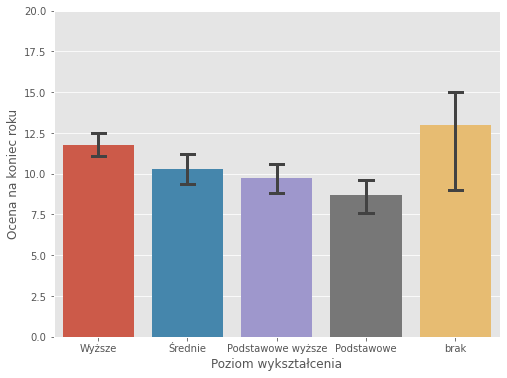

In [30]:
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x='Medu',y='G3',data=data,
            order=["Wyższe","Średnie","Podstawowe wyższe", 'Podstawowe', 'brak'],capsize=.15,errwidth=3)

ax.set_xlabel("Poziom wykształcenia")
ax.set_ylabel("Ocena na koniec roku")

ax.set_ylim(0,20);


## Analiza korelacji


Czy wiek jest powiązany z nieobecnościami ucznia?

H0: Wiek nie koreluje z nieobecnościami ucznia.<br>
H1: Wiek koreluje z nieobecnościami ucznia.

In [31]:
pg.corr(x=data['age'], y=data['absences']).round(3)

,n,r,CI95%,p-val,BF10,power
pearson,395,0.175,"[0.08, 0.27]",0.0,28.025,0.939


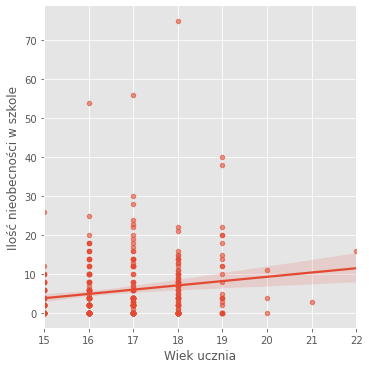

In [32]:
g = sns.lmplot(x = "age", y = "absences", data = data, scatter_kws = {"s":20, "alpha":0.6})

g.set(xlabel = "Wiek ucznia", ylabel = "Ilość nieobecności w szkole");

W celu sprawdzenia czy wiek jest powiązany z nieobecnościami ucznia wykonano analizę korelacji r Pearsona. Wynik analizy okazał się istotny statystycznie, r =0.175 ; p < 0.001. Istnieje słaba, dodatnia korelacja pomiędzy zmiennymi. (Wraz ze wzrostem wieku ucznia wzrasta ilość nieobecności w szkole).

## Analiza regresji

Czy mozna przewidywać ocenę końcową ucznia na podstawie ilości nieobecności w roku szkolnym i wieku ucznia?

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('G3 ~ age + absences', data = data).fit()
results = model.summary()

In [34]:
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     6.092
Date:                Wed, 26 Jan 2022   Prob (F-statistic):            0.00248
Time:                        12:34:41   Log-Likelihood:                -1155.1
No. Observations:                 395   AIC:                             2316.
Df Residuals:                     392   BIC:                             2328.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.5681      3.013      6.827      0.000      14.645      26.491
age           -0.6207      0.181     -3.422      0.001      -0.977      -0.264
absences       0.0369      0.029      1.278      0.202      -0.020       0.094
==============================================================================
Omnibus:                       27.044   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.671
Skew:                          -0.668   Prob(JB):                     2.19e-07
Kurtosis:                       3.278   Cond. No.                         238.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

W celu sprawdzenia czy można przewidywać ocenę końcową ucznia na podstawie ilości czasu wolnego i czasu spędzonego na spotakaniach towarzyskich, wykonano analizę wielozmiennowej regresji liniowej. Proponowany model okazał się dobrze dopasowany do danych, F(2, 392) = 6.092 ; p = 0.00248. Model ten przewiduje 2.5% wariancji oceny. Równanie regresji można zapisać za pomocą wzoru:

**ocena = 20.5681 -0.6207 * age + 0.0369 * absences**

##### Analiza cząstkowa

In [35]:
reg =data[['absences', 'age', 'G3']]
reg.pcorr()

,absences,age,G3
absences,1.000000,0.183278,0.064390
age,0.183278,1.000000,-0.170314
G3,0.064390,-0.170314,1.000000


Wiek ucznia (r = -0.170 ; p = 0.001) jest słabo, negatywnie powiązany z ocena końcową. Natomiast ilość nieobecności (r = 0.064 ; p = 0.202) jest nieistontny statystycznie predyktorem oceny uczniów.


##### Wizualizacja danych

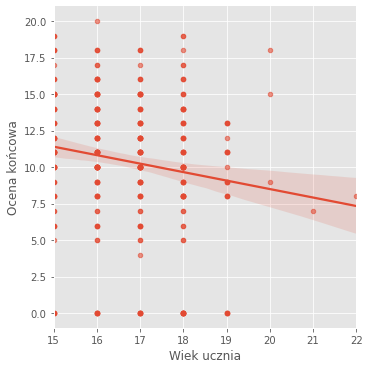

In [36]:
g = sns.lmplot(x = "age", y = "G3", data = data, scatter_kws = {"s":20, "alpha":0.6})

g.set(xlabel = "Wiek ucznia", ylabel = "Ocena końcowa");

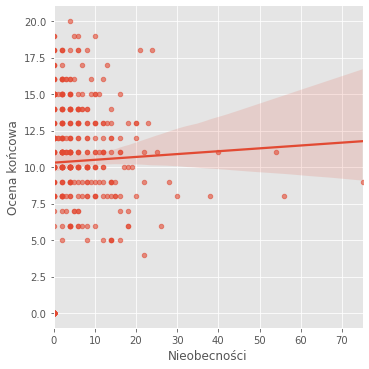

In [37]:
g = sns.lmplot(x = "absences", y = "G3", data = data, scatter_kws = {"s":20, "alpha":0.6})

g.set(xlabel = "Nieobecności", ylabel = "Ocena końcowa");

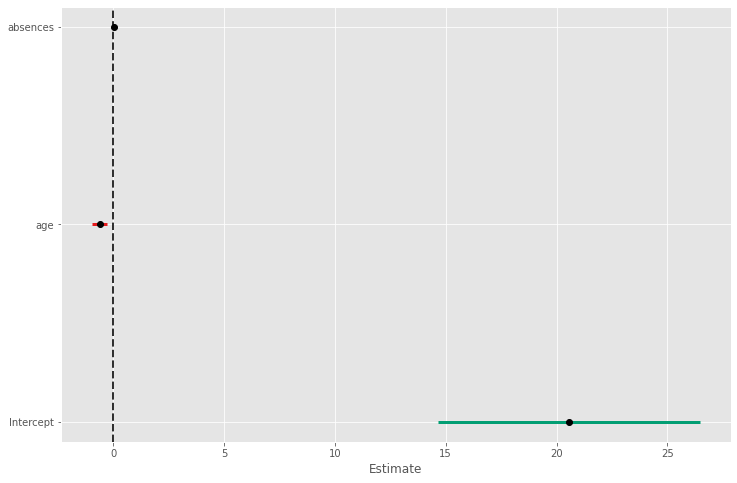

In [38]:
plot_estimates(model=model)